# UFC Fight Prediction Model

In [50]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Data Loading

In [51]:
master_data = pd.read_csv("../data/ufc_master_dataset.csv")

In [52]:
# Reorder columns into a logical order
master_data = master_data[[
    # Fight metadata
    "RedFighter", "BlueFighter", "Date", "Location", "Country", "Gender", "TitleBout", "WeightClass", "NumberOfRounds", "EmptyArena",
    
    # Fighter stats
    "RedWins", "BlueWins", "RedLosses", "BlueLosses", "RedDraws", "BlueDraws",
    "RedCurrentWinStreak", "BlueCurrentWinStreak", "RedCurrentLoseStreak", "BlueCurrentLoseStreak",
    "RedLongestWinStreak", "BlueLongestWinStreak",
    "RedTotalRoundsFought", "BlueTotalRoundsFought",
    "RedTotalTitleBouts", "BlueTotalTitleBouts",

    "RedWinsByDecisionUnanimous", "BlueWinsByDecisionUnanimous",
    "RedWinsByDecisionMajority", "BlueWinsByDecisionMajority",
    "RedWinsByDecisionSplit", "BlueWinsByDecisionSplit",
    "RedWinsByKO", "BlueWinsByKO",
    "RedWinsByTKODoctorStoppage", "BlueWinsByTKODoctorStoppage",
    "RedWinsBySubmission", "BlueWinsBySubmission",

    "RedAvgSigStrLanded", "BlueAvgSigStrLanded",
    "RedAvgSigStrPct", "BlueAvgSigStrPct",
    "RedAvgSubAtt", "BlueAvgSubAtt",
    "RedAvgTDLanded", "BlueAvgTDLanded",
    "RedAvgTDPct", "BlueAvgTDPct",

    "RedStance", "BlueStance",
    "RedAge", "BlueAge",
    "RedHeightCms", "BlueHeightCms",
    "RedReachCms", "BlueReachCms",
    "RedWeightLbs", "BlueWeightLbs",

    # Fighter rankings
    "RMatchWCRank", "BMatchWCRank", "RPFPRank", "BPFPRank",
    "RFlyweightRank", "BFlyweightRank", "RBantamweightRank", "BBantamweightRank",
    "RFeatherweightRank", "BFeatherweightRank", "RLightweightRank", "BLightweightRank",
    "RWelterweightRank", "BWelterweightRank", "RMiddleweightRank", "BMiddleweightRank",
    "RLightHeavyweightRank", "BLightHeavyweightRank", "RHeavyweightRank", "BHeavyweightRank",
    "RWFlyweightRank", "BWFlyweightRank", "RWFeatherweightRank", "BWFeatherweightRank",
    "RWStrawweightRank", "BWStrawweightRank", "RWBantamweightRank", "BWBantamweightRank",

    # Differentials
    "WinDif", "LossDif", "WinStreakDif", "LoseStreakDif", "LongestWinStreakDif", "TotalRoundDif", "TotalTitleBoutDif",
    "KODif", "SigStrDif", "SubDif", "AvgSubAttDif",  "AvgTDDif",
    "HeightDif", "ReachDif", "AgeDif",
    "BetterRank",

    # Odds
    "RedOdds", "BlueOdds", "RedExpectedValue", "BlueExpectedValue",
    "RedDecOdds", "BlueDecOdds", "RSubOdds", "BSubOdds", "RKOOdds", "BKOOdds",

    # Fight outcomes
    "Winner", "Finish", "FinishDetails", "FinishRound", "FinishRoundTime", "TotalFightTimeSecs"
]]

## Data Exploration

In [53]:
master_data.head(5)

,RedFighter,BlueFighter,Date,Location,Country,Gender,TitleBout,WeightClass,NumberOfRounds,EmptyArena,...,RSubOdds,BSubOdds,RKOOdds,BKOOdds,Winner,Finish,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs
0,Alexandre Pantoja,Kai Asakura,12/7/2024,"Las Vegas, Nevada, USA",USA,MALE,True,Flyweight,5,NaN,...,150.0,2500.0,400.0,350.0,Red,SUB,Rear Naked Choke,2.0,2:05,425.0
1,Shavkat Rakhmonov,Ian Machado Garry,12/7/2024,"Las Vegas, Nevada, USA",USA,MALE,False,Welterweight,3,NaN,...,180.0,3000.0,240.0,700.0,Red,U-DEC,NaN,5.0,5:00,1500.0
2,Ciryl Gane,Alexander Volkov,12/7/2024,"Las Vegas, Nevada, USA",USA,MALE,False,Heavyweight,3,NaN,...,1100.0,3000.0,350.0,1100.0,Red,S-DEC,NaN,3.0,5:00,900.0
3,Bryce Mitchell,Kron Gracie,12/7/2024,"Las Vegas, Nevada, USA",USA,MALE,False,Featherweight,3,NaN,...,380.0,1400.0,500.0,4000.0,Red,KO/TKO,Elbows,3.0,0:39,639.0
4,Nate Landwehr,Dooho Choi,12/7/2024,"Las Vegas, Nevada, USA",USA,MALE,False,Featherweight,3,NaN,...,500.0,700.0,300.0,250.0,Blue,KO/TKO,Elbows,3.0,3:21,801.0


In [54]:
master_data.shape

(6528, 118)

In [55]:
master_data.describe()

,NumberOfRounds,EmptyArena,RedWins,BlueWins,RedLosses,BlueLosses,RedDraws,BlueDraws,RedCurrentWinStreak,BlueCurrentWinStreak,...,RedExpectedValue,BlueExpectedValue,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,FinishRound,TotalFightTimeSecs
count,6528.000000,5042.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,...,6301.000000,6302.000000,5441.000000,5412.000000,5192.000000,5169.000000,5194.000000,5168.000000,5906.000000,5906.000000
mean,3.185509,0.153114,4.628064,3.145680,2.566789,1.863664,0.031097,0.023131,1.101562,0.957567,...,96.658224,165.054566,308.333395,425.870288,884.048151,1100.497775,510.891606,636.463235,2.424145,657.536234
std,0.577441,0.360133,4.505498,3.712852,2.703546,2.170130,0.187999,0.156327,1.760767,1.406786,...,85.891109,137.689177,250.750088,325.940028,601.826547,671.106177,426.563458,465.014634,1.007887,360.383418
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.761900,8.333300,-440.000000,-200.000000,-370.000000,-1250.000000,-550.000000,-400.000000,1.000000,5.000000
25%,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.215700,66.666700,170.000000,222.000000,439.750000,600.000000,225.000000,310.000000,1.000000,299.000000
50%,3.000000,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,66.666700,130.000000,250.000000,350.000000,750.000000,1000.000000,420.000000,525.000000,3.000000,900.000000
75%,3.000000,0.000000,7.000000,5.000000,4.000000,3.000000,0.000000,0.000000,2.000000,1.000000,...,130.000000,215.000000,400.000000,550.000000,1200.000000,1450.000000,700.000000,875.000000,3.000000,900.000000
max,5.000000,1.000000,33.000000,31.000000,21.000000,16.000000,2.000000,2.000000,18.000000,12.000000,...,775.000000,1300.000000,2400.000000,3000.000000,4665.000000,5000.000000,4000.000000,4000.000000,5.000000,1500.000000


In [56]:
master_data.describe(include="object")

,RedFighter,BlueFighter,Date,Location,Country,Gender,WeightClass,RedStance,BlueStance,BetterRank,Winner,Finish,FinishDetails,FinishRoundTime
count,6528,6528,6528,6528,6528,6528,6528,6528,6525,6528,6528,6290,2892,5906
unique,1661,1922,564,150,36,2,13,4,5,3,2,7,39,294
top,Jim Miller,Charles Oliveira,11/19/2016,"Las Vegas, Nevada, USA",USA,MALE,Lightweight,Orthodox,Orthodox,neither,Red,U-DEC,Punch,5:00
freq,29,18,24,2139,2450,5727,1074,4877,4844,4684,3787,2404,677,2956


## Data Preprocessing

In [57]:
# Add Fight ID
master_data = master_data.reset_index(drop=True)
master_data["FightID"] = master_data.index + 1

# Convert fight date to datetime
master_data["Date"] = pd.to_datetime(master_data["Date"])

# Drop unused columns
master_data = master_data.drop(columns=["Location", "EmptyArena", "FinishRoundTime"])

# Clean string columns
master_data["Country"] = master_data["Country"].str.strip()
master_data["Gender"] = master_data["Gender"].str.strip().str.capitalize()
master_data["WeightClass"] = master_data["WeightClass"].str.replace("Catch Weight", "Catchweight")
master_data["BlueStance"] = master_data["BlueStance"].str.strip()

# Flip sign of differential columns so they represent Red − Blue
dif_cols = [col for col in master_data.columns if col.endswith("Dif")]
master_data[dif_cols] = master_data[dif_cols] * -1

## Feature Engineering

### Date

In [58]:
# Extract year
master_data["Year"] = master_data["Date"].dt.year

# Build fighter-level history
red_history = master_data[["RedFighter", "Date"]].rename(columns={"RedFighter": "Fighter"})
blue_history = master_data[["BlueFighter", "Date"]].rename(columns={"BlueFighter": "Fighter"})
fighter_history = pd.concat([red_history, blue_history], ignore_index=True)

# Sort and compute days since last fight
fighter_history = (
    fighter_history
    .sort_values(["Fighter", "Date"])
    .assign(DaysSinceLastFight=lambda df: df.groupby("Fighter")["Date"].diff().dt.days)
)

# Merge back to master_data
for color in ["Red", "Blue"]:
    master_data = master_data.merge(
        fighter_history.rename(
            columns={
                "Fighter": f"{color}Fighter",
                "DaysSinceLastFight": f"{color}DaysSinceLastFight"
            }
        ),
        on=[f"{color}Fighter", "Date"],
        how="left"
    )

# Debut flags
master_data["IsRedDebut"] = master_data["RedDaysSinceLastFight"].isna().astype(int)
master_data["IsBlueDebut"] = master_data["BlueDaysSinceLastFight"].isna().astype(int)

### Rank

In [59]:
def transform_rank(x):
    """
    Transform raw ranking values into a normalized strength score.

    Rules:
    - Missing value → 0 (unranked)
    - 0 → 16 (champion)
    - 1–15 → mapped to 15–1 (so higher = stronger)
    
    This ensures that larger values consistently represent stronger rankings.
    """
    if pd.isna(x):
        return 0
    elif x == 0:
        return 16
    else:
        return 16 - x

In [60]:
# Identify rank columns
rank_cols = [c for c in master_data.columns if c.endswith("Rank") and c != "BetterRank"]

# Apply transformation
master_data[rank_cols] = master_data[rank_cols].map(transform_rank)

# Create differentials for current fight weight class rank and pound-for-pound rank
master_data["MatchWCRankDif"] = master_data["RMatchWCRank"] - master_data["BMatchWCRank"]
master_data["PFPRankDif"] = master_data["RPFPRank"] - master_data["BPFPRank"]

# Red & Blue rank columns (exclude WC/PFP and BetterRank)
rank_cols_red = [c for c in rank_cols if c.startswith("R") and c not in ["RMatchWCRank", "RPFPRank"]]
rank_cols_blue = [c for c in rank_cols if c.startswith("B") and c not in ["BMatchWCRank", "BPFPRank"]]

# Collapse into one strength score per fighter
master_data["RedRankStrength"] = master_data[rank_cols_red].max(axis=1)
master_data["BlueRankStrength"] = master_data[rank_cols_blue].max(axis=1)

# Calculate rank strength differential
master_data["RankStrengthDif"] = master_data["RedRankStrength"] - master_data["BlueRankStrength"]

# Drop raw rank columns
master_data = master_data.drop(columns=rank_cols_red + rank_cols_blue + ["BetterRank"])

### Differentials

In [61]:
# Combine Red/Blue decision totals
master_data["RedWinsByDecision"] = (
    master_data["RedWinsByDecisionMajority"]
    + master_data["RedWinsByDecisionSplit"]
    + master_data["RedWinsByDecisionUnanimous"]
)

master_data["BlueWinsByDecision"] = (
    master_data["BlueWinsByDecisionMajority"]
    + master_data["BlueWinsByDecisionSplit"]
    + master_data["BlueWinsByDecisionUnanimous"]
)

# Create additional differentials
diff_stats = ["WinsByDecision", "AvgSigStrPct", "AvgTDPct"]

for stat in diff_stats:
    master_data[f"{stat}Dif"] = master_data[f"Red{stat}"] - master_data[f"Blue{stat}"]

# Rename for clarity
master_data = master_data.rename(columns={
    "WinsByDecisionDif": "DecisionDif",
    "AvgSigStrPctDif": "SigStrPctDif",
    "AvgSubAttDif": "SubAttDif",
    "AvgTDDif": "TDDif",
    "AvgTDPctDif": "TDPctDif"
})

# Drop decision total columns since individual decision type totals are already included
master_data = master_data.drop(columns=["RedWinsByDecision", "BlueWinsByDecision"])

### Odds

In [62]:
def odds_to_prob(odds):
    """
    Convert American odds to implied probability.

    - Negative odds: |odds| / (|odds| + 100)
    - Positive odds: 100 / (odds + 100)
    """
    odds = np.asarray(odds, dtype=float)
    return np.where(odds < 0, np.abs(odds) / (np.abs(odds) + 100), 100 / (odds + 100))

# Apply for Red and Blue
master_data["RedProb"] = odds_to_prob(master_data["RedOdds"])
master_data["BlueProb"] = odds_to_prob(master_data["BlueOdds"])

### Finalize

In [63]:
# Encode winner: Red = 1, Blue = 0
master_data['Winner'] = [1 if winner == 'Red' else 0 for winner in master_data.Winner]

In [64]:
# Define column order
col_order = [
    # Fight metadata
    "FightID", "RedFighter", "BlueFighter", "Date", "Year", "Country", "Gender", "TitleBout", "WeightClass", "NumberOfRounds",
    
    # Fighter stats
    "IsRedDebut", "IsBlueDebut", "RedDaysSinceLastFight", "BlueDaysSinceLastFight",
    "RedWins", "BlueWins", "RedLosses", "BlueLosses", "RedDraws", "BlueDraws",
    "RedCurrentWinStreak", "BlueCurrentWinStreak", "RedCurrentLoseStreak", "BlueCurrentLoseStreak",
    "RedLongestWinStreak", "BlueLongestWinStreak",
    "RedTotalRoundsFought", "BlueTotalRoundsFought",
    "RedTotalTitleBouts", "BlueTotalTitleBouts",

    "RedWinsByDecisionUnanimous", "BlueWinsByDecisionUnanimous",
    "RedWinsByDecisionMajority", "BlueWinsByDecisionMajority",
    "RedWinsByDecisionSplit", "BlueWinsByDecisionSplit",
    "RedWinsByKO", "BlueWinsByKO",
    "RedWinsByTKODoctorStoppage", "BlueWinsByTKODoctorStoppage",
    "RedWinsBySubmission", "BlueWinsBySubmission",

    "RedAvgSigStrLanded", "BlueAvgSigStrLanded",
    "RedAvgSigStrPct", "BlueAvgSigStrPct",
    "RedAvgSubAtt", "BlueAvgSubAtt",
    "RedAvgTDLanded", "BlueAvgTDLanded",
    "RedAvgTDPct", "BlueAvgTDPct",

    "RedStance", "BlueStance",
    "RedAge", "BlueAge",
    "RedHeightCms", "BlueHeightCms",
    "RedReachCms", "BlueReachCms",
    "RedWeightLbs", "BlueWeightLbs",

    # Fighter rankings
    "RMatchWCRank", "BMatchWCRank", "RPFPRank", "BPFPRank", "RedRankStrength", "BlueRankStrength",

    # Differentials
    "WinDif", "LossDif", "WinStreakDif", "LoseStreakDif", "LongestWinStreakDif", "TotalRoundDif", "TotalTitleBoutDif",
    "DecisionDif", "KODif", "SigStrDif", "SigStrPctDif", "SubDif", "SubAttDif", "TDDif", "TDPctDif",
    "AgeDif", "HeightDif", "ReachDif",

    # Odds
    "RedOdds", "BlueOdds", "RedProb", "BlueProb", "RedExpectedValue", "BlueExpectedValue",
    "RedDecOdds", "BlueDecOdds", "RSubOdds", "BSubOdds", "RKOOdds", "BKOOdds",

    # Fight outcomes
    "Winner", "Finish", "FinishDetails", "FinishRound", "TotalFightTimeSecs"
]

# Reorder dataset
master_data = master_data[col_order]

In [65]:
master_data.head(5)

,FightID,RedFighter,BlueFighter,Date,Year,Country,Gender,TitleBout,WeightClass,NumberOfRounds,...,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,Winner,Finish,FinishDetails,FinishRound,TotalFightTimeSecs
0,1,Alexandre Pantoja,Kai Asakura,2024-12-07,2024,USA,Male,True,Flyweight,5,...,800.0,150.0,2500.0,400.0,350.0,1,SUB,Rear Naked Choke,2.0,425.0
1,2,Shavkat Rakhmonov,Ian Machado Garry,2024-12-07,2024,USA,Male,False,Welterweight,3,...,650.0,180.0,3000.0,240.0,700.0,1,U-DEC,NaN,5.0,1500.0
2,3,Ciryl Gane,Alexander Volkov,2024-12-07,2024,USA,Male,False,Heavyweight,3,...,450.0,1100.0,3000.0,350.0,1100.0,1,S-DEC,NaN,3.0,900.0
3,4,Bryce Mitchell,Kron Gracie,2024-12-07,2024,USA,Male,False,Featherweight,3,...,1100.0,380.0,1400.0,500.0,4000.0,1,KO/TKO,Elbows,3.0,639.0
4,5,Nate Landwehr,Dooho Choi,2024-12-07,2024,USA,Male,False,Featherweight,3,...,550.0,500.0,700.0,300.0,250.0,0,KO/TKO,Elbows,3.0,801.0


In [66]:
master_data.describe()

,FightID,Date,Year,NumberOfRounds,IsRedDebut,IsBlueDebut,RedDaysSinceLastFight,BlueDaysSinceLastFight,RedWins,BlueWins,...,BlueExpectedValue,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,Winner,FinishRound,TotalFightTimeSecs
count,6528.000000,6528,6528.000000,6528.000000,6528.000000,6528.000000,5815.000000,5129.000000,6528.000000,6528.000000,...,6302.000000,5441.000000,5412.000000,5192.000000,5169.000000,5194.000000,5168.000000,6528.000000,5906.000000,5906.000000
mean,3264.500000,2018-03-19 18:17:12.352941312,2017.699449,3.185509,0.109222,0.214308,216.718143,213.726457,4.628064,3.145680,...,165.054566,308.333395,425.870288,884.048151,1100.497775,510.891606,636.463235,0.580116,2.424145,657.536234
min,1.000000,2010-03-21 00:00:00,2010.000000,3.000000,0.000000,0.000000,7.000000,13.000000,0.000000,0.000000,...,8.333300,-440.000000,-200.000000,-370.000000,-1250.000000,-550.000000,-400.000000,0.000000,1.000000,5.000000
25%,1632.750000,2014-11-08 00:00:00,2014.000000,3.000000,0.000000,0.000000,132.000000,120.000000,1.000000,0.000000,...,66.666700,170.000000,222.000000,439.750000,600.000000,225.000000,310.000000,0.000000,1.000000,299.000000
50%,3264.500000,2018-05-27 00:00:00,2018.000000,3.000000,0.000000,0.000000,175.000000,168.000000,3.000000,2.000000,...,130.000000,250.000000,350.000000,750.000000,1000.000000,420.000000,525.000000,1.000000,3.000000,900.000000
75%,4896.250000,2021-10-03 18:00:00,2021.000000,3.000000,0.000000,0.000000,252.000000,245.000000,7.000000,5.000000,...,215.000000,400.000000,550.000000,1200.000000,1450.000000,700.000000,875.000000,1.000000,3.000000,900.000000
max,6528.000000,2024-12-07 00:00:00,2024.000000,5.000000,1.000000,1.000000,3199.000000,3100.000000,33.000000,31.000000,...,1300.000000,2400.000000,3000.000000,4665.000000,5000.000000,4000.000000,4000.000000,1.000000,5.000000,1500.000000
std,1884.615611,NaN,4.079010,0.577441,0.311941,0.410373,162.461228,177.068614,4.505498,3.712852,...,137.689177,250.750088,325.940028,601.826547,671.106177,426.563458,465.014634,0.493577,1.007887,360.383418


In [67]:
master_data.describe(include="object")

,RedFighter,BlueFighter,Country,Gender,WeightClass,RedStance,BlueStance,Finish,FinishDetails
count,6528,6528,6528,6528,6528,6528,6525,6290,2892
unique,1661,1922,27,2,13,4,4,7,39
top,Jim Miller,Charles Oliveira,USA,Male,Lightweight,Orthodox,Orthodox,U-DEC,Punch
freq,29,18,4344,5727,1074,4877,4844,2404,677


## Data Visualization

In [68]:
# Correlation of numeric features with target
num_corr_cols = master_data.select_dtypes(include=["number"]).columns.drop("Winner")

corr_series = master_data[num_corr_cols].corrwith(master_data["Winner"]).abs()
corr_series = corr_series.sort_values(ascending=False)

# Display
for col, corr in corr_series.round(2).items():
    print(col, corr)

RedProb 0.36
BlueProb 0.36
BlueOdds 0.35
RedOdds 0.34
RedExpectedValue 0.32
BlueExpectedValue 0.32
BlueDecOdds 0.23
BKOOdds 0.21
RKOOdds 0.2
BSubOdds 0.18
RedDecOdds 0.17
RSubOdds 0.16
WinStreakDif 0.12
RedAge 0.12
TDDif 0.11
BlueAge 0.11
SigStrPctDif 0.11
RedLosses 0.1
RedAvgSigStrPct 0.09
RedAvgTDLanded 0.08
RedWinsByDecisionSplit 0.08
BlueAvgTDLanded 0.08
RedCurrentWinStreak 0.07
TDPctDif 0.07
RedCurrentLoseStreak 0.07
BlueCurrentWinStreak 0.07
TotalRoundDif 0.07
RedAvgTDPct 0.07
ReachDif 0.06
BlueAvgSigStrPct 0.06
SubAttDif 0.06
SigStrDif 0.05
RedTotalRoundsFought 0.05
BlueLosses 0.05
RedAvgSubAtt 0.05
KODif 0.05
WinDif 0.04
LongestWinStreakDif 0.04
RPFPRank 0.04
HeightDif 0.04
RedDaysSinceLastFight 0.04
BlueAvgTDPct 0.04
RedRankStrength 0.03
RedWinsByKO 0.03
DecisionDif 0.03
RedWins 0.03
AgeDif 0.03
BlueAvgSubAtt 0.03
RMatchWCRank 0.03
BlueWinsByDecisionSplit 0.03
BlueDraws 0.03
BlueDaysSinceLastFight 0.03
RedAvgSigStrLanded 0.03
BlueCurrentLoseStreak 0.03
BlueAvgSigStrLanded 0.03

In [69]:
master_data["Winner"].value_counts(normalize=True)

Winner
1    0.580116
0    0.419884
Name: proportion, dtype: float64

In [70]:
# Favorite fighter based on odds
conditions = [
    master_data["RedOdds"] < master_data["BlueOdds"],
    master_data["BlueOdds"] < master_data["RedOdds"]
]
choices = ["Red", "Blue"]

master_data["Favorite"] = np.select(conditions, choices, default="Pick'em")

# Distribution
master_data["Favorite"].value_counts(normalize=True)

Favorite
Red        0.598652
Blue       0.347273
Pick'em    0.054075
Name: proportion, dtype: float64

In [71]:
# Drop Favorite
master_data = master_data.drop(columns=["Favorite"])

## Train/Test Split

In [72]:
drop_cols = [
    "FightID", "RedFighter", "BlueFighter", "Date",
    "RedOdds", "BlueOdds", "RedExpectedValue", "BlueExpectedValue",
    "RedDecOdds", "BlueDecOdds", "RSubOdds", "BSubOdds", "RKOOdds", "BKOOdds",
    "Winner", "Finish", "FinishDetails", "FinishRound", "TotalFightTimeSecs",
]

# Features & target
X = master_data.drop(columns=drop_cols)
y = master_data["Winner"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [73]:
# Split numeric & categorical columns
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

# Preprocessing: impute + scale numeric, impute + encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
        
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first"))
        ]), categorical_cols),
    ]
)

# Pipeline with preprocessing + PCA
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=0.95, random_state=42))
])

# Fit & transform
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

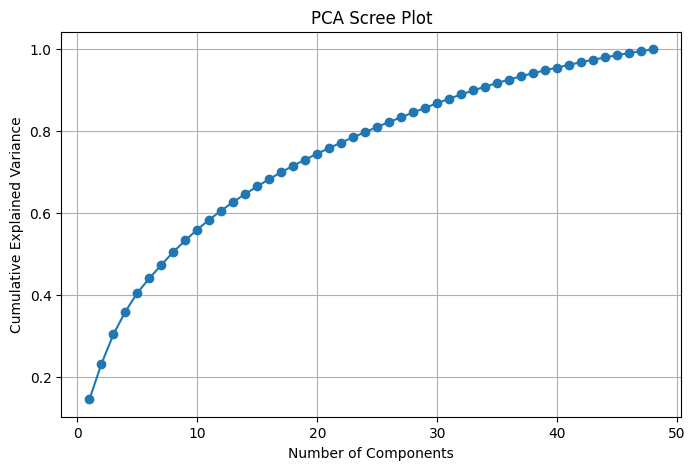

In [74]:
# Preprocess training data into numeric form
X_train_prepared = X_train

# Fit PCA
pca = PCA().fit(X_train_prepared)

# Cumulative explained variance
explained_var = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()

## Model Selection

### Base Model

In [75]:
# Initialize the model
log_reg = LogisticRegression(random_state=42)

# Cross-validation with 5 folds
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring="accuracy")

print("Mean CV Accuracy:", cv_scores.mean().round(3))
print("Std CV Accuracy:", cv_scores.std().round(3))

Mean CV Accuracy: 0.663
Std CV Accuracy: 0.007


### Multiple Model Run

In [76]:
# Define models
models = {
    # Linear models
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    # Instance-based
    "K-Nearest Neighbors": KNeighborsClassifier(),
    # Margin-based
    "Support Vector Machine": SVC(random_state=42),
    # Trees
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    # Ensembles
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

# Train & evaluate
results = []

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    train_acc = round(accuracy_score(y_train, y_pred_train), 3)
    test_acc = round(accuracy_score(y_test, y_pred_test), 3)

    results.append((name, train_acc, test_acc))

# Display the results
results = (
    pd.DataFrame(results, columns=["Model", "Train Accuracy", "Test Accuracy"])
    .sort_values(by="Test Accuracy", ascending=False)
    .reset_index(drop=True)
)

results

,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.670,0.642
1,Gradient Boosting,0.752,0.642
2,Support Vector Machine,0.771,0.638
3,Random Forest,1.000,0.632
4,XGBoost,1.000,0.618
5,K-Nearest Neighbors,0.742,0.574
6,Decision Tree,1.000,0.557


In [77]:
# Hyperparameter grid for Logistic Regression
param_grid_logreg = {
    "penalty": ["l1", "l2", "elasticnet", None],   # Type of regularization
    "C": [0.01, 0.1, 1, 10, 100],                  # Inverse of regularization strength
    "solver": ["lbfgs", "liblinear", "saga"],      # Optimization algorithms
    "max_iter": [1000],                            # Ensure convergence
    "l1_ratio": [0, 0.5, 1]                        # Only used if penalty="elasticnet"
}

# Randomized search
logreg_random = RandomizedSearchCV(
    estimator=LogisticRegression(),
    param_distributions=param_grid_logreg,
    n_iter=25,
    cv=5,
    scoring="accuracy",
    verbose=0,
    random_state=42,
    n_jobs=-1
)

# Fit search
logreg_random.fit(X_train, y_train)

# Best model
logreg_best_model = logreg_random.best_estimator_

# Evaluate
y_pred_best_logreg = logreg_best_model.predict(X_test)
logreg_random_accuracy = round(accuracy_score(y_test, y_pred_best_logreg), 3)

# Print results
print("Best Parameters:", logreg_random.best_params_)
print("Mean CV Accuracy:", round(logreg_random.best_score_, 3))
print("Test Accuracy:", logreg_random_accuracy)

Best Parameters: {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 1000, 'l1_ratio': 1, 'C': 0.1}
Mean CV Accuracy: 0.663
Test Accuracy: 0.642


c:\Users\giobu\OneDrive\Desktop\UFC Fight Prediction Model\venv\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
45 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\giobu\OneDrive\Desktop\UFC Fight Prediction Model\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\giobu\OneDrive\Desktop\UFC Fight Prediction Model\venv\Lib\site-packages\sklearn\base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
  

### Alternative (Walk-Forward) Train/Test Split

In [82]:
from sklearn.model_selection import TimeSeriesSplit

# Sort chronologically
temp_data = master_data.sort_values("Date").reset_index(drop=True)

X = temp_data.drop(columns=drop_cols)
y = temp_data["Winner"]

# Walk-forward split
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold_accuracies = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Identify column types for preprocessing
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

    # Preprocessing: impute + scale numeric, impute + encode categorical
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="mean")),
                ("scaler", StandardScaler())
            ]), numeric_cols),

            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first"))
            ]), categorical_cols),
        ]
    )

    # Build pipeline: preprocessing → PCA → tuned Logistic Regression
    pipeline_temp = Pipeline([
        ("preprocessor", preprocessor),
        ("pca", PCA(n_components=0.95, random_state=42)),
        ("model", logreg_best_model)  # best Logistic Regression
    ])

    # Fit pipeline on this fold
    pipeline_temp.fit(X_train, y_train)

    # Predict on this fold’s test set
    y_pred = pipeline_temp.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    fold_accuracies.append(acc)
    print(f"Fold {fold} Accuracy: {acc:.3f}")

print("\nAverage accuracy across folds:", round(sum(fold_accuracies) / len(fold_accuracies), 3))

c:\Users\giobu\OneDrive\Desktop\UFC Fight Prediction Model\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\giobu\OneDrive\Desktop\UFC Fight Prediction Model\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [0, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\giobu\OneDrive\Desktop\UFC Fight Prediction Model\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l

Fold 1 Accuracy: 0.640
Fold 2 Accuracy: 0.655
Fold 3 Accuracy: 0.644
Fold 4 Accuracy: 0.662
Fold 5 Accuracy: 0.658

Average accuracy across folds: 0.652


c:\Users\giobu\OneDrive\Desktop\UFC Fight Prediction Model\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\giobu\OneDrive\Desktop\UFC Fight Prediction Model\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\giobu\OneDrive\Desktop\UFC Fight Prediction Model\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
